In [1]:
include("../../src/utilities.jl")
include("../../src/simple_canonical_model_functions.jl")
include("../../src/model_with_ribosomes_functions.jl")
include("../../src/canonical_two_stage_model_with_division_functions.jl")
using Catalyst, DifferentialEquations, PyPlot, Statistics, SpecialFunctions

In [2]:
function beta_3_exact(beta, gamma, rho, T)
    return (3*beta *gamma *(6 *gamma ^2*T^2*
   exp(gamma  *T)-3 *gamma ^2 *T^2-4 *gamma *T*
   exp(gamma*T)+2 *gamma *T+2*exp(gamma *
   T)-2))/(rho*(26 *gamma ^3 *T^3*
   exp(gamma*T)-13 *gamma ^3 *T^3-12 *gamma ^2*
   T^2* exp(gamma  *T)+12 *gamma ^2 *T^2-6 *gamma* 
   T *exp(gamma * T)-6 *gamma  *T+12 *exp(gamma* 
   T)-12))
end

beta_3_exact (generic function with 1 method)

In [3]:
function negative_binomial(x, mean, std)
    p = 1-mean/std^2
    r = mean^2/(std^2-mean)
    return SpecialFunctions.gamma.(x .+ r) ./ (SpecialFunctions.gamma.(x .+ 1) .* SpecialFunctions.gamma.(r)) .* (1-p) .^ r .* p .^x
end

negative_binomial (generic function with 1 method)

In [4]:
function simulate_cycle(model, p, t0, t_fin, T, species_0, saveat)
    tstops = [t0+T:T:t_fin;]
    
    prob = DiscreteProblem(model, species_0, (t0,t_fin), p)
    jump_prob = JumpProblem(model, prob, Direct(), save_positions=(false,false))
        
    condition(u,t,integrator) = t%27.5==0.0
    affect!(integrator) = integrator.u = Utilities.partition_species(integrator.u)
    cb = DiscreteCallback(condition,affect!)
    
    sol = solve(jump_prob, SSAStepper(), saveat=saveat, callback=cb, tstops=tstops)
    return sol
end

function simulate_stochastic_cycle(model, p, t0, t_fin, T, species_0, N, saveat)
   prob = DiscreteProblem(
        model,
        species_0,
        (t0,t_fin),
        p
    )
    jump_prob = JumpProblem(model, prob, Direct())
    
    function affect!(integrator)
        integrator.u = Utilities.partition_species(integrator.u)
        integrator.u[length(integrator.u)] = 0
    end
        
    condition(u,t,integrator) = u[length(u)]==N
    cb = DiscreteCallback(condition,affect!)
    sol = solve(jump_prob, SSAStepper(), callback=cb, saveat=saveat)
    pop!(sol.u)
    pop!(sol.t)
    return sol
end

simulate_stochastic_cycle (generic function with 1 method)

## Model I

In [5]:
sc2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
        delta, p-->0
end alpha beta gamma delta

Model ##ReactionSystem#257 with 4 equations
States (2):
  m(t)
  p(t)
Parameters (4):
  alpha
  beta
  gamma
  delta

In [6]:
alph = 1.0
beta = 0.2
gamma = 1.29*0.19
delta = 0.0228
    
prob = DiscreteProblem(sc2s, [round(alph/gamma), round(alph*beta/gamma/delta)], (0.,12000000.), [alph, beta, gamma ,delta])
jump_prob = JumpProblem(sc2s, prob, Direct())

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

retcode: Default
Interpolation: Piecewise constant interpolation
t: 55602414-element Vector{Float64}:
 0.0
 0.6168294203221576
 0.7589145876390055
 0.9486670296820676
 1.0
 1.0540831894735159
 1.130304385022517
 1.5170075327582577
 2.0
 2.816932736897872
 3.0
 3.1724309753055526
 3.347831409733429
 ⋮
 1.1999996336893024e7
 1.1999996364147222e7
 1.199999667112536e7
 1.1999997e7
 1.1999997834400252e7
 1.1999998e7
 1.199999805813671e7
 1.1999999e7
 1.1999999625462556e7
 1.1999999640213773e7
 1.1999999762089929e7
 1.2e7
u: 55602414-element Vector{Vector{Float64}}:
 [4.0, 36.0]
 [3.0, 36.0]
 [4.0, 36.0]
 [3.0, 36.0]
 [3.0, 36.0]
 [4.0, 36.0]
 [3.0, 36.0]
 [3.0, 35.0]
 [3.0, 35.0]
 [3.0, 34.0]
 [3.0, 34.0]
 [3.0, 33.0]
 [3.0, 32.0]
 ⋮
 [5.0, 45.0]
 [4.0, 45.0]
 [4.0, 46.0]
 [4.0, 46.0]
 [4.0, 47.0]
 [4.0, 47.0]
 [3.0, 47.0]
 [3.0, 47.0]
 [3.0, 46.0]
 [3.0, 45.0]
 [4.0, 45.0]
 [4.0, 45.0]

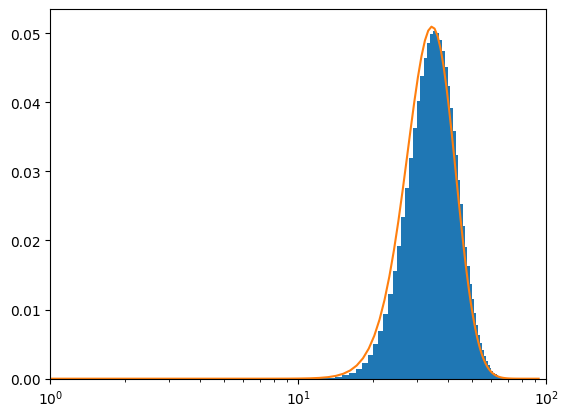

In [7]:
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

x = LinRange(0,max, max)
y = negative_binomial(
    x,
    SimpleCanonicalModel.p(alph, beta, gamma, delta),
    sqrt(SimpleCanonicalModel.p_var(alph, beta, gamma, delta))
)
hist(p, density=true, bins=bins)
xlim([1,100])
xscale("log")
plot(x,y)
savefig("../../data/distributions/model_I.svg")

In [8]:
println(mean(p))
println(mean(m))
println(var(p))
println(var(m))

36.399045804018506
4.489445098552736
63.60108381653437
4.321746523132881


## Model II

In [9]:
c2s = @reaction_network begin
        alpha,  0-->m
        beta, m-->p + m
        gamma,  m-->0
    end alpha beta gamma

Model ##ReactionSystem#258 with 3 equations
States (2):
  m(t)
  p(t)
Parameters (3):
  alpha
  beta
  gamma

In [10]:
alph = 1.0
beta = 0.2
gamma = 0.2
T=27.5


sol = simulate_cycle(c2s, [alph, beta, gamma], 0.0, 20000000.0, T,
        [
            round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
            round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0))
        ],
        0.9
    )
    

retcode: Default
Interpolation: Piecewise constant interpolation
t: 23676768-element Vector{Float64}:
  0.0
  0.9
  1.8
  2.7
  3.6
  4.5
  5.4
  6.3
  7.2
  8.1
  9.0
  9.9
 10.8
  ⋮
  1.99999908e7
  1.99999917e7
  1.99999926e7
  1.99999935e7
  1.9999994400000002e7
  1.99999953e7
  1.99999962e7
  1.99999971e7
  1.9999998e7
  1.9999998900000002e7
  1.99999998e7
  2.0e7
u: 23676768-element Vector{Vector{Float64}}:
 [2.0, 25.0]
 [2.0, 26.0]
 [1.0, 26.0]
 [0.0, 27.0]
 [1.0, 27.0]
 [2.0, 27.0]
 [1.0, 27.0]
 [1.0, 27.0]
 [1.0, 28.0]
 [2.0, 28.0]
 [2.0, 28.0]
 [1.0, 28.0]
 [2.0, 29.0]
 ⋮
 [4.0, 33.0]
 [5.0, 34.0]
 [5.0, 36.0]
 [6.0, 39.0]
 [5.0, 40.0]
 [3.0, 40.0]
 [4.0, 41.0]
 [3.0, 41.0]
 [3.0, 41.0]
 [5.0, 41.0]
 [2.0, 44.0]
 [2.0, 44.0]

In [11]:
p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][2]

end

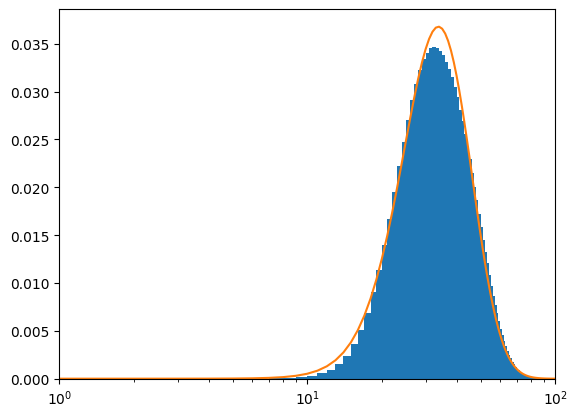

In [12]:
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)
x = LinRange(1,125, 125)
y = negative_binomial(
    x,
    CanonicalTwoStageModel.p_time_av(alph, beta, gamma, T),
    sqrt(CanonicalTwoStageModel.p_var_time_av(alph, beta, gamma, T))
)

plt.xscale("log")
hist(p, density=true, bins=bins)
plot(x, y)
xlim([1,100])
savefig("../../data/distributions/model_II.svg")

In [13]:
println(mean(p))
println(mean(m))
println(var(p))
println(var(m))

36.727028748180494
4.461552776122146
130.29490043048125
5.030439133071701


## Model III

In [14]:
mwr = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
end alpha beta gamma rho

Model ##ReactionSystem#259 with 4 equations
States (3):
  m(t)
  r(t)
  p(t)
Parameters (4):
  alpha
  beta
  gamma
  rho

In [15]:
alph = 1.0
gamma = 0.2
rho = 1.0
T=27.5
beta = 0.99*beta_3_exact(0.2, gamma, rho, T)


sol = simulate_cycle(mwr, [alph, beta, gamma, rho], 0.0, 10000000.0, T,
        [
            round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
            round(ModelWithRibosomes.r(rho, T, 0)),
            round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        ],
        2.4
    )

retcode: Default
Interpolation: Piecewise constant interpolation
t: 4893940-element Vector{Float64}:
  0.0
  2.4
  4.8
  7.2
  9.6
 12.0
 14.4
 16.8
 19.2
 21.6
 24.0
 26.4
 27.5
  ⋮
  9.9999792e6
  9.9999816e6
  9.999984e6
  9.9999864e6
  9.9999888e6
  9.99999e6
  9.99999e6
  9.9999912e6
  9.9999936e6
  9.999996e6
  9.9999984e6
  1.0e7
u: 4893940-element Vector{Vector{Float64}}:
 [2.0, 28.0, 26.0]
 [2.0, 30.0, 27.0]
 [2.0, 30.0, 27.0]
 [1.0, 30.0, 27.0]
 [3.0, 32.0, 27.0]
 [1.0, 32.0, 27.0]
 [2.0, 36.0, 27.0]
 [2.0, 38.0, 28.0]
 [3.0, 40.0, 28.0]
 [4.0, 42.0, 28.0]
 [3.0, 48.0, 32.0]
 [6.0, 50.0, 34.0]
 [7.0, 50.0, 35.0]
 ⋮
 [7.0, 49.0, 50.0]
 [6.0, 49.0, 53.0]
 [6.0, 52.0, 56.0]
 [8.0, 55.0, 59.0]
 [8.0, 56.0, 64.0]
 [9.0, 56.0, 67.0]
 [4.0, 27.0, 33.0]
 [4.0, 28.0, 34.0]
 [5.0, 29.0, 36.0]
 [6.0, 34.0, 37.0]
 [5.0, 40.0, 43.0]
 [5.0, 40.0, 43.0]

In [16]:
p = zeros(length(sol.u))
m = zeros(length(sol.u))
r = zeros(length(sol.u))

for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    r[i] = sol.u[i][2]
    p[i] = sol.u[i][3]

end
p

4893940-element Vector{Float64}:
 26.0
 27.0
 27.0
 27.0
 27.0
 27.0
 27.0
 28.0
 28.0
 28.0
 32.0
 34.0
 35.0
  ⋮
 50.0
 53.0
 56.0
 59.0
 64.0
 67.0
 33.0
 34.0
 36.0
 37.0
 43.0
 43.0

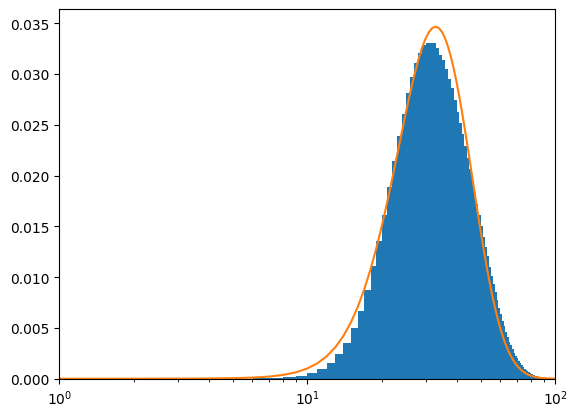

In [17]:
x = LinRange(1,125, 125)
y = negative_binomial(
    x,
    ModelWithRibosomes.p_time_av(alph, beta, gamma, rho, T),
    sqrt(ModelWithRibosomes.p_var_time_av(alph, beta, gamma, rho, T))
)
#histogram(p, normed=true, linecolor=:match, xlim=[0,250])
#plot!(x, y)
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

hist(p, density=true, bins=bins)
plot(x, y)
plt.xscale("log")
xlim([1,100])
savefig("../../data/distributions/model_III.svg")

In [18]:
println(mean(m))
println(mean(r))
println(mean(p))
println(var(m))
println(var(r))
println(var(p))

4.407380147692861
41.21525131080479
36.89613297261511
5.083461531462821
122.9248083103228
161.27703582257703


## Model IV

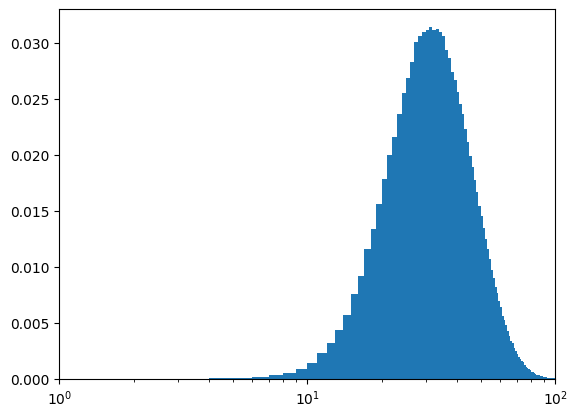

In [19]:
slc2sm = @reaction_network begin
    alpha,  0-->m
    beta, m -->p + m
    gamma,  m-->0
    k, 0-->n
end alpha beta gamma k

alph = 0.87*1.0
gamma = 0.2
T=27.5
beta = 1.07*0.2
N = 10
k = N/T

sol = simulate_stochastic_cycle(slc2sm, [alph, beta, gamma, k], 0., 1000000., T,
    [
        round(CanonicalTwoStageModel.mrna(alph, gamma, T, 0)),
        round(CanonicalTwoStageModel.approximate_protein_mean(alph, beta, gamma, T, 0)),
        0
    ],
    N,
    2.5
)

p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][2]

end
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(p, density=true, bins=bins)
savefig("../../data/distributions/model_IV.svg")

In [20]:
println(mean(m))
println(mean(p))
println(var(m))
println(var(p))

4.473426774457333
36.61130255912241
4.5907624060469345
179.76558240517753


## Model V

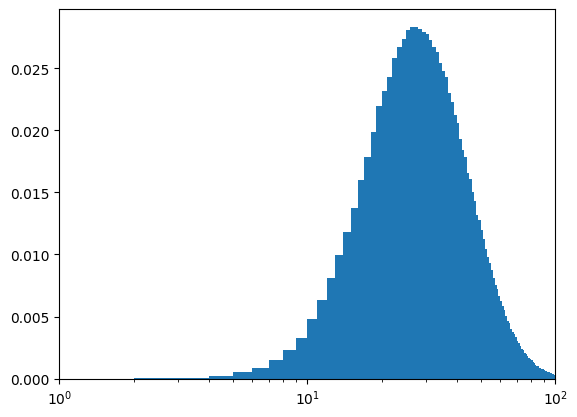

In [21]:
slm = @reaction_network begin
    alpha,  0-->m
    beta, m + r-->p + m + r
    gamma,  m-->0
    rho, 0-->r
    k, 0-->n
end alpha beta gamma rho k

alph = 0.87*1.0
gamma = 0.2
rho = 1.0
T=27.5
beta = 0.99*beta_3_exact(0.2, gamma, rho, T)
N = 10
k = N/T

sol = simulate_stochastic_cycle(slm, [alph, beta, gamma, rho, k], 0., 1000000., T,
    [
        round(ModelWithRibosomes.mrna(alph, gamma, T, 0)),
        round(ModelWithRibosomes.r(rho, T, 0)),
        round(ModelWithRibosomes.p(alph, beta, gamma, rho, T, 0)),
        0
    ],
    N,
    2.5
)

p = zeros(length(sol.u))
m = zeros(length(sol.u))
for i in 1:length(sol.u)
    m[i] = sol.u[i][1]
    p[i] = sol.u[i][3]

end
min = Int(minimum(p))
max = Int(maximum(p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(p, density=true, bins=bins)
savefig("../../data/distributions/model_V.svg")

In [22]:
println(mean(m))
println(mean(r))
println(mean(p))
println(var(m))
println(var(r))
println(var(p))

4.364207135262144
41.21525131080479
35.825643231316036
4.567009673804051
122.9248083103228
276.3412535158279


## Model VI

In [9]:
using DiffEqJump

alph = 0.76*1.0
gamma = 0.2
rho = 1.0
T=27.5
beta = 1.04*beta_3_exact(0.2, gamma, rho, T)
N = 10
k = N/T

R = 8 # point of replication
p = (alph, gamma, beta, rho, k)

rate1(u,p,t) = u[4] >= R ? 2 * alph : alph
function affect1!(integrator)
  integrator.u[1] += 1         # m -> m + 1
end
jump = VariableRateJump(rate1,affect1!)

rate2(u,p,t) = gamma * u[1]
function affect2!(integrator)
  integrator.u[1] -= 1         # m -> m + 1
end
jump2 = ConstantRateJump(rate2,affect2!)

rate3(u,p,t) = beta * u[1] * u[3]
function affect3!(integrator)
    integrator.u[2] += 1   # p -> p + 1
end
jump3 = ConstantRateJump(rate3, affect3!)
    
rate4(u,p,t) = rho
function affect4!(integrator)
    integrator.u[3] +=1
end
jump4=ConstantRateJump(rate4, affect4!)

rate5(u,p,t) = k
function affect5!(integrator)   # n -> n + 1
    integrator.u[4] += 1
end
jump5 = ConstantRateJump(rate5, affect5!)

function condition(u,t,integrator) # Event when event_f(u,t) == 0
    u[4] >= N
end

function affect!(integrator)
    partition = Utilities.partition_species(integrator.u[1:3])
    integrator.u[1] = partition[1]
    integrator.u[2] = partition[2]
    integrator.u[3] = partition[3]
    integrator.u[4] = 0
end

clb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

In [ ]:
tspan = (0.0,2000000.0)
function f(du,u,p,t)
  du[5] = 0
end
u₀   = [2.0,20.0,5.0, 0.0, 0.0]
prob = ODEProblem(f,u₀,tspan,p)
jump_prob = JumpProblem(prob,Direct(),jump,jump2,jump3, jump4, jump5)
sol = solve(jump_prob,Tsit5(), callback=clb, maxiters=100000000) # Saveat doesn't work, need to do something else...
    
t = sol.t
m = map(x -> x[1], sol.u)
p = map(x -> x[2], sol.u)
r = map(x -> x[3], sol.u)

n = map(x -> x[4], sol.u)

In [ ]:
tau = 10.0 # Frequency of time savings
t_0 = t[1]
t_max = last(t)
times = t_0:10:t_max
measurements = zeros(length(times))

function get_value_at_time(measurements, times, t)
    for i in 1:length(times)
        if t == times[i] || (t > times[i] && t < times[i+1])
            return measurements[i]
        end
    end
    return NaN
end

function convert_solution_to_evenly_spaced_measurements(counts, t, tau)
    t_0 = t[1]
    t_max = last(t)
    times = t_0:tau:t_max
    measurements = zeros(length(times))
    for i in 1:length(times)
        measurements[i] = get_value_at_time(counts, t, times[i])
    end
    measurements
end

In [ ]:
evenly_spaced_p = convert_solution_to_evenly_spaced_measurements(p, t, 10.0)
evenly_spaced_m = convert_solution_to_evenly_spaced_measurements(m, t, 10.0)
evenly_spaced_r = convert_solution_to_evenly_spaced_measurements(m, t, 10.0)



min = Int(minimum(evenly_spaced_p))
max = Int(maximum(evenly_spaced_p))
bins = Array(min:1:max)

plt.xscale("log")
xlim([1,100])
hist(evenly_spaced_p, density=true, bins=bins)
savefig("../../data/distributions/model_VI.svg")

In [ ]:
println(mean(evenly_spaced_p))
println(mean(evenly_spaced_m))
println(mean(evenly_spaced_r))
println(var(evenly_spaced_p))
println(var(evenly_spaced_m))
println(var(evenly_spaced_r))